In [51]:
prediction_type <- "classification" #classification  #regression
datasets_path   <- paste0('E:/Mestrado_ranker/datasets_scores/',prediction_type,'/')
scores_path     <- paste0('E:/Mestrado_ranker/R_output_analisys/data_scores/',prediction_type,'/')
plots_path      <- paste0('E:/Mestrado_ranker/R_output_analisys/plots/',prediction_type,'/')
friedman_path   <- paste0('E:/Mestrado_ranker/R_output_analisys/friedman/',prediction_type,'/')

dataset_names <- list.files(path=datasets_path, full.names = FALSE, pattern = "\\_scores$")
dataset_names <- gsub("_scores", "", dataset_names)

noisy_features <- list("001", "002", "004", "008", "016", "032", "064","128","256","512","1024")
scoring_measures <- list(
  'binary_rs1',
  'binary_rs2',
  'binary_rs3',
  'geometricMean_rs1',
  'geometricMean_rs2',
  'geometricMean_rs3',
  'gini_rs1',
  'gini_rs2',
  'gini_rs3',
  'oobScore_rs1',
  'oobScore_rs2',
  'oobScore_rs3'
)

In [77]:
#CRIAR FUNCAO PARA TRANSFORMACAO DOS DADOS DE MYDATA.AVERAGE PARA VEC_NEWFORMAT
cantao_dataset_restructure <- function(mydata.average){
  #creating a new empty vector and transforming it to a data frame (para poder usar o rbind)
  newformat <- as.data.frame(newformat <- c())
  
  #transforming the column-values to line-values for each centrality
  #and insert it to the new data frame (as new row)
  newformat <- rbind(newformat, data.frame(orientation="g",   centrality="katz",  centrality_or_forest="c", value=mydata.average$averageGKatz))
  newformat <- rbind(newformat, data.frame(orientation="g",   centrality="eigen", centrality_or_forest="c", value=mydata.average$averageGEigen))
  newformat <- rbind(newformat, data.frame(orientation="g",   centrality="str",   centrality_or_forest="c", value=mydata.average$averageGStr))
  newformat <- rbind(newformat, data.frame(orientation="in",  centrality="katz",  centrality_or_forest="c", value=mydata.average$averageGDirInKatz))
  newformat <- rbind(newformat, data.frame(orientation="in",  centrality="eigen", centrality_or_forest="c", value=mydata.average$averageGDirInEigen))
  newformat <- rbind(newformat, data.frame(orientation="in",  centrality="str",   centrality_or_forest="c", value=mydata.average$averageGDirInStr))
  newformat <- rbind(newformat, data.frame(orientation="out", centrality="katz",  centrality_or_forest="c", value=mydata.average$averageGDirOutKatz))
  newformat <- rbind(newformat, data.frame(orientation="out", centrality="eigen", centrality_or_forest="c", value=mydata.average$averageGDirOutEigen))
  newformat <- rbind(newformat, data.frame(orientation="out", centrality="str",   centrality_or_forest="c", value=mydata.average$averageGDirOutStr))
  newformat <- rbind(newformat, data.frame(orientation="rf", centrality="rf", centrality_or_forest="f", value=mydata.average$averageForestRanking))
  #INSERIR COLUNA MEASURE_NAME? ou substituir a coluna atual centrality por measure_name?
  
  #inserting the ramaining columns to the new data frame (no need for transformation here)
  newformat <- cbind(newformat, dataset=mydata.average$dataset, noise=mydata.average$noisePercentual, R=mydata.average$noisyFeatures)
  return(newformat)
}

In [ ]:
for (scoring_measure in scoring_measures){
  mydata.average <- NULL
  for (dataset_name in dataset_names){
    for (kfold in seq(10)){
      for (noise in noisy_features){
        filePathAverage <- paste0(datasets_path,dataset_name,"_scores/",sprintf("%03d", kfold),"/",noise,"/score/average_",dataset_name,"_",scoring_measure,".txt")
        newdataaverage  <- read.table(filePathAverage, header=TRUE, sep="\t")
          
        #creating a new column and filling with the dataset name
        newdataaverage$dataset <- dataset_name

        #creating a new column and filling with the amount of noise used
        newdataaverage$noisyFeatures <- noise

        #binding each file to the single file of results
        mydata.average   <- rbind(mydata.average, newdataaverage)
#        mydata.std   <- rbind(mydata.std, newdatastd)
        #printing the paths used to double-check
        #print(filePathAverage)
      }
    }
    cat(scoring_measure, ': ', dataset_name, 'OK\n')
  }
  #MUDAR NOME DATASET NOVO "vec_newformat
  vec_newformat  <- NULL
  vec_newformat  <- cantao_dataset_restructure(mydata.average)
  mydata.average <- NULL
  #converter coluna R de factor para numeric
  vec_newformat$R <- as.numeric(levels(vec_newformat$R))[vec_newformat$R]
  write.csv(vec_newformat, file=paste0(scores_path,'scores_',scoring_measure,'.csv'), row.names = FALSE)
  vec_newformat  <- NULL
}

## FUNCTION to summarize dataset and plot graph
#### based on 4 given information: dataset, x_data, y_data and group_by_data

In [46]:
cantao_plot <- function(dataset, x_data, y_data, group_by_data, group_by_label, measure='mean', visu='points'){
    require(ggplot2)
    require(gridExtra)
    if(visu == 'points'){
        #require loads the package only if its not already loaded
        require(FSA)
        Sum = Summarize(y_data ~ x_data + group_by_data, data=dataset)
        #standard error
        #Sum$se = Sum$sd / sqrt(Sum$n)
        require(dplyr)
        Sum <- Sum %>%
        group_by(x_data) %>%
        mutate(width = 0.5 * as.numeric(x_data))
      if(measure == 'mean'){
          y_data  = Sum$mean
          err_min = Sum$mean - Sum$sd
          err_max = Sum$mean + Sum$sd
      }else if(measure == 'median'){# == 'median'
          y_data  = Sum$median
          err_min = Sum$median - (Sum$Q3 - Sum$Q1)
          err_max = Sum$median + (Sum$Q3 - Sum$Q1)
      }else{
          print("please set the measure variable to 'mean' or 'median'")
      }
      pd = position_dodge(0.8) #0.5   ### How much to jitter the points on the plot
      p <- ggplot(Sum,                ### The data frame to use. 
                  #aes(x     = factor(x_data, levels = c("1","2","4","8","16","32","64","128","256","512","1024")), #remover log2() e usar string no eixo X
                  aes(x     = factor(x_data, levels = unique(x_data)),
                      y     = y_data,
                      color = group_by_data,
                      group = group_by_data)) +
           #legend to the group_by variable
           scale_color_discrete(name=group_by_label) +
           scale_shape_discrete(name=group_by_label) + 
           geom_point(aes(shape=group_by_data),  size  = 3.0, position = pd) +
           geom_errorbar(aes(ymin  = err_min,  #se
                             ymax  = err_max), #se
                         #linetype=group_by_data),
                         width = 1.0, #30.5
                         size  = 0.5, 
                         position = pd) +
           #geom_line(aes(linetype=group_by_data),  size  = 2.0, position = pd) + 
           geom_line(size  = 0.7, position = pd)
    }else if(visu == 'boxplot'){
        err_min = 0
        err_max = 1
        p <- ggplot(dataset,                
                      aes(x    = factor(x_data),                  #x_data
                          y    = value,              #y_data
                          fill = group_by_data)) +      #group_by_data
            geom_boxplot() +
            labs(fill=group_by_label)
    }else{
        print("please set the visu variable to 'points' or 'boxplot'")
    }
    p <- p + 
    theme_bw() + #background of the plotting area 
    theme(plot.title = element_text(hjust = 0.5)) +
    xlab(expression(paste("Total Features ", (x * rho + rho)))) + #(2^x * rho + rho)
    ylab("Mean Ranking Score") +
    ggtitle(label = dataset$title)+
    ylim(
       min(0, err_min), 
       max(1, err_max)
    )
    return (p)
}

##  Loads structured dataset averages for each weight and ranking score (rs) and plot averages graphs #


In [54]:
start_time <- Sys.time()

measure = 'mean' # 'median'  'mean'
visu    = 'points' #'points' 'boxplot'

files <- list.files(path=scores_path, full.names = TRUE, pattern = "\\.csv$")
plot_sufix <- '_85datasets_10folds.pdf'

for (file in files){
  vec_newformat <- read.table(file, header=TRUE, sep=",")
  #removes the first and last part of the string to keep only scoring measure name
  sub_partial <- sub(".*scores_", "", file)
  scoring_measure <- sub("\\..*", "", sub_partial)
  
  output_plot_dir = paste0(plots_path,scoring_measure,'/')
  if (!dir.exists(output_plot_dir)){
    dir.create(file.path(output_plot_dir), recursive=TRUE)
  }
  # NDC --- transposed of DNC
  #saving all 12 subsets for NDC in ndc[[]] list
  ndc <- list() #Noise Dataset Centrality (NDC)
  i=1
  for(noi in c(5,10,20,40)){ #for each noise percentage on examples
    for(ori in c("g", "in", "out")){ #for each orientation in graph
      ndc[[i]] <- subset(vec_newformat, noise == noi & (orientation == ori | centrality_or_forest == "f"))
      ndc[[i]]$title <- paste0('Noise Rate: ', noi,'%;', ' Orientation: ', ori)
      i=i+1
    }
  }
  #plotting each of the subsets for NDC
  p <- list()
  i = 1
  for (data_subset in ndc){ 
    p[[i]] <- cantao_plot(dataset = data_subset,
                          #x_data = log2(data_subset$R),
                          x_data = as.factor(data_subset$R),
                          y_data = data_subset$value,
                          group_by_data = data_subset$centrality,
                          group_by_label = 'Centrality',
                          measure,
                          visu)
    i=i+1
  }
  #showing plot
  #grid.arrange(grobs = p, ncol=3)
  #saving plot
  g <- arrangeGrob(grobs = p, ncol=3)
  ggsave(file=paste0(output_plot_dir,'NDC_',scoring_measure, plot_sufix), g,width = 13, height = 13)
  
  # NCD --- transposed of CND
  ncd <- list()
  i=1
  for (noi in c(5,10,20,40)){
    for(cent in c("katz", "eigen", "str")){
      ncd[[i]] <- subset(vec_newformat, noise == noi & (centrality == cent | centrality_or_forest == "f"))
      ncd[[i]]$title <- paste0('Noise: ', noi,'%;', ' Centrality: ', cent)
      i=i+1
    }
  }
  #plotting each of the subsets for NCD
  p <- list()
  i = 1
  for (data_subset in ncd){ #
    p[[i]] <- cantao_plot(dataset = data_subset,
                          x_data = data_subset$R,
                          y_data = data_subset$value,
                          group_by_data = data_subset$orientation,
                          group_by_label = 'Orientation',
                          measure,
                          visu)
    i=i+1
  }
  #grid.arrange(grobs = p, ncol=3)
  g <- arrangeGrob(grobs = p, ncol=3) 
  ggsave(file=paste0(output_plot_dir,'NCD_',scoring_measure,plot_sufix), g,width = 13, height = 13)
  
  
  # DCN --- transposed of CDN 
  dcn <- list()
  i=1
  for(ori in c("g", "in", "out", "rf")){
    for(cent in c("katz", "eigen", "str")){
      dcn[[i]] <- subset(vec_newformat, orientation == ori & (centrality == cent | centrality_or_forest == "f"))
      #dcn[[i]]$noise <- as.factor(dcn[[i]]$noise)
      dcn[[i]]$title <- paste0('Orientation: ', ori,'; Centrality: ', cent)
      i=i+1
    }
  }
  #plotting each of the subsets for DCN
  p <- list()
  i = 1
  for (data_subset in dcn){ #
    p[[i]] <- cantao_plot(dataset = data_subset,
                          x_data = data_subset$R,
                          y_data = data_subset$value,
                          group_by_data = as.character(data_subset$noise),
                          group_by_label = 'Noise',
                          measure,
                          visu)
    i=i+1
  }
  #grid.arrange(grobs = p, ncol=3)
  g <- arrangeGrob(grobs = p, ncol=3)
  ggsave(file=paste0(output_plot_dir,'DCN_',scoring_measure,plot_sufix), g, width = 13, height = 13)
}

end_time <- Sys.time()
end_time - start_time

Time difference of 5.018504 mins

## Loads structured dataset scores for each weight and ranking score (rs) and saves friedman table

In [3]:
files <- list.files(path=scores_path, full.names = TRUE, pattern = "\\.csv$")
for (file in files){
  vec_newformat <- read.table(file, header=TRUE, sep=",")
  #removes the first and last part of the string to keep only scoring measure name
  sub_partial <- sub(".*scores_", "", file)
  scoring_measure <- sub("\\..*", "", sub_partial)
  
  output_friedman_dir = paste0(friedman_path,scoring_measure,'/')
  if (!dir.exists(output_friedman_dir)){
    dir.create(file.path(output_friedman_dir), recursive=TRUE)
  }
  directions   <- unique(vec_newformat$orientation)   #list("g", "in", "out", "rf")
  directions   <- setdiff(directions, "rf") # getting all centralities that are not "rf"
  centralities <- unique(vec_newformat$centrality) #list("katz", "eigen", "str", "rf")
  noises       <- unique(vec_newformat$noise) #list(5,10,20,40)
  rs           <- unique(vec_newformat$R) #1,2,4,8,16..1024
  #-----------------------------------------------------------------------------
  #--------------------------------Friedman-DCN----------------------------------
  for (dir in directions){  #D .. 3 files
    #11linhas = R... 13 colunas = katz_5, katz_10, katz_20, katz_40, eigen_5...
    vec_metric <- matrix(, nrow = 11, ncol = 16)
    #personalized column names using 'dir_cent_noi'
    dataset_col_names <- list()
    
    i=0
    for (cent in centralities){ #C
      #cat("\ncent: ", cent)
      if (cent == "rf") #para cent=='rf' nao utiliza as direcoes 'g', 'in' e 'out'
        a <- subset(vec_newformat, centrality=='rf') 
      else
        a <- subset(vec_newformat, orientation==dir & centrality==cent)
      for (noi in noises){ #N
        i=i+1
        dataset_col_names[length(dataset_col_names)+1] <- paste0(dir, "_", cent, "_", noi)
        #cat("\nnoi: ", noi)
        #cat(paste0(dir, "_", cent, "_", noi))
        b<-subset(a, noise==noi)
        
        j=0
        for (r in rs){
          #cat("\nr: " ,r)
          c<-subset(b, R==r)
          j=j+1
          vec_metric[j,i] <- mean(c$value)
          #cat("value: ", vec_metric[j,i])
          #cat("i: ", i, "j: ", j)
        }
      }
    }
    #create a dataframe from the matrix and rename the columns
    metrics_mean <- as.data.frame(vec_metric)
    colnames(metrics_mean) <- dataset_col_names
    #saving table to a CSV file
    write.csv(metrics_mean,file=paste0(output_friedman_dir,'DCN_',dir,'_',scoring_measure,'.csv'),row.names=FALSE)
    cat(scoring_measure,': DCN - OK\n')
  }
  #-----------------------------------------------------------------------------
  #-------------------------------Friedman-NDC----------------------------------
  for (noi in noises){ #N ...4 files
    #creating empty matrix to store the mean results
    #10 metrics and 7 noisy feat slices
    vec_metric <- matrix(, nrow = 11, ncol = 12) #files: noises(4) 
    dataset_col_names <- list()                  #columns: directions(3)*centralities(4) 
    i=0
    #for (r in rs){#for each slice of 01R, 02R...
    for(dir in directions){ #D
      #cat("\ndir: ", dir)
      a <- subset(vec_newformat, noise == noi & orientation==dir | noise == noi & orientation=='rf')
      for(cent in centralities){ #C
        i=i+1
        dataset_col_names[length(dataset_col_names)+1] <- paste0(noi, "_", dir, "_", cent)
        #cat("\ncent: ", cent)
        #cat(paste0(noi, "_", dir, "_", cent))
        if (cent == "rf") #para cent=='rf' nao utiliza as direcoes 'g', 'in' e 'out'
          b <- subset(a, centrality=='rf')
        else  
          b <- subset(a, centrality==cent)
        
        j=0
        for (r in rs){
          #cat("\nr: " ,r)
          c<-subset(b, R==r)
          j=j+1
          vec_metric[j,i] <- mean(c$value)
          #cat("value: ", vec_metric[j,i])
          #cat("i: ", i, "j: ", j)
        }
      }
    }
    #create a dataframe from the matrix and rename the columns
    metrics_mean <- as.data.frame(vec_metric)
    colnames(metrics_mean) <- dataset_col_names
    #saving table to a CSV file
    write.csv(metrics_mean,file=paste0(output_friedman_dir,'NDC_',noi,'_',scoring_measure,'.csv'),row.names=FALSE)
    cat(scoring_measure,': NDC - OK\n')
  }
  #-----------------------------------------------------------------------------
  #-------------------------------Friedman-DNC----------------------------------
  for (dir in directions){  #D .. 3 files
    #11linhas = R... 13 colunas = katz_5, katz_10, katz_20, katz_40, eigen_5...
    vec_metric <- matrix(, nrow = 11, ncol = 16)
    #personalized column names using 'dir_cent_noi'
    dataset_col_names <- list()
    i=0
    for (noi in noises){ #N
      #cat("\nnoi: ", noi)
      a <- subset(vec_newformat, orientation==dir & noise==noi | orientation=='rf' & noise==noi)
      for (cent in centralities){ #C
        i=i+1
        dataset_col_names[length(dataset_col_names)+1] <- paste0(dir, "_", noi, "_", cent)
        #cat("\ncent: ", cent)
        #cat(paste0(dir, "_", noi, "_", cent))
        if (cent == "rf") #para cent=='rf' nao utiliza as direcoes 'g', 'in' e 'out'
          b<-subset(a, centrality=='rf')
        else
          b<-subset(a, centrality==cent)
        
        j=0
        for (r in rs){
          #cat("\nr: " ,r)
          c<-subset(b, R==r)
          j=j+1
          vec_metric[j,i] <- mean(c$value)
          #cat("value: ", vec_metric[j,i])
          #cat("i: ", i, "j: ", j)
        }
      }
    }
    #create a dataframe from the matrix and rename the columns
    metrics_mean <- as.data.frame(vec_metric)
    colnames(metrics_mean) <- dataset_col_names
    #saving table to a CSV file
    write.csv(metrics_mean,file=paste0(output_friedman_dir,'DNC_',dir,'_',scoring_measure,'.csv'),row.names=FALSE)
    cat(scoring_measure,': DNC - OK\n')
  }
}

binary_rs1 : DCN - OK
binary_rs1 : DCN - OK
binary_rs1 : DCN - OK
binary_rs1 : NDC - OK
binary_rs1 : NDC - OK
binary_rs1 : NDC - OK
binary_rs1 : NDC - OK
binary_rs1 : DNC - OK
binary_rs1 : DNC - OK
binary_rs1 : DNC - OK
binary_rs2 : DCN - OK
binary_rs2 : DCN - OK
binary_rs2 : DCN - OK
binary_rs2 : NDC - OK
binary_rs2 : NDC - OK
binary_rs2 : NDC - OK
binary_rs2 : NDC - OK
binary_rs2 : DNC - OK
binary_rs2 : DNC - OK
binary_rs2 : DNC - OK
binary_rs3 : DCN - OK
binary_rs3 : DCN - OK
binary_rs3 : DCN - OK
binary_rs3 : NDC - OK
binary_rs3 : NDC - OK
binary_rs3 : NDC - OK
binary_rs3 : NDC - OK
binary_rs3 : DNC - OK
binary_rs3 : DNC - OK
binary_rs3 : DNC - OK
geometricMean_rs1 : DCN - OK
geometricMean_rs1 : DCN - OK
geometricMean_rs1 : DCN - OK
geometricMean_rs1 : NDC - OK
geometricMean_rs1 : NDC - OK
geometricMean_rs1 : NDC - OK
geometricMean_rs1 : NDC - OK
geometricMean_rs1 : DNC - OK
geometricMean_rs1 : DNC - OK
geometricMean_rs1 : DNC - OK
geometricMean_rs2 : DCN - OK
geometricMean_rs2 : D

# Testing plot

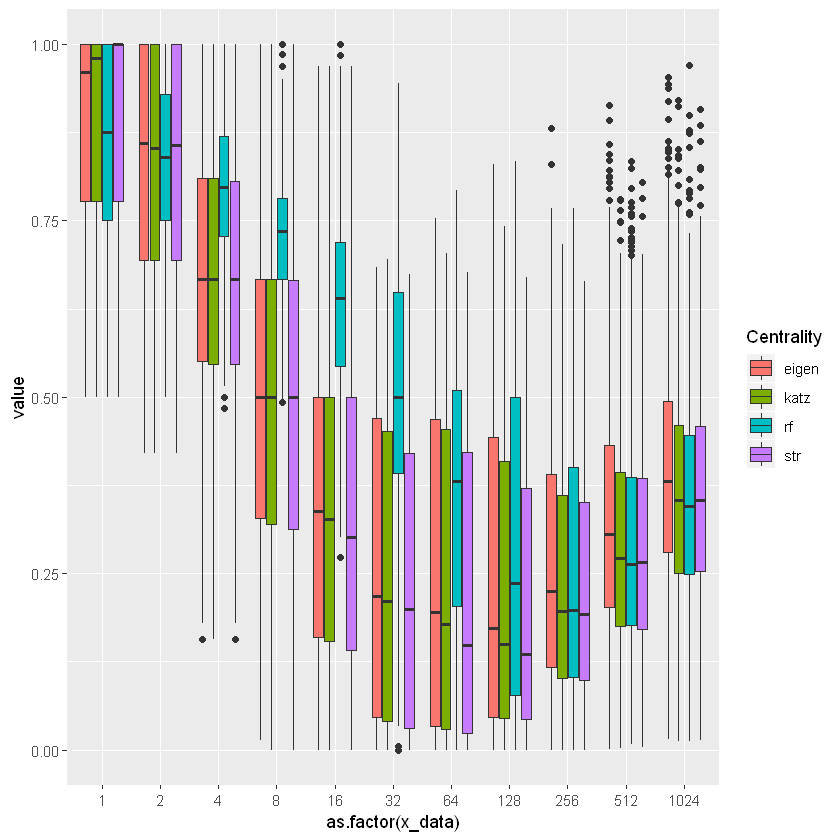

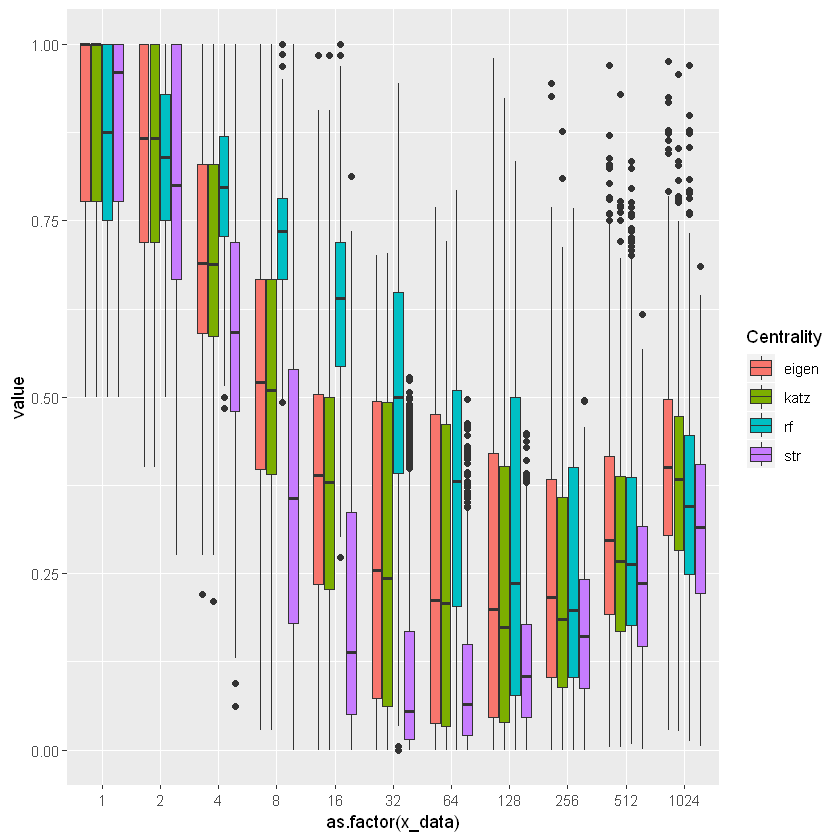

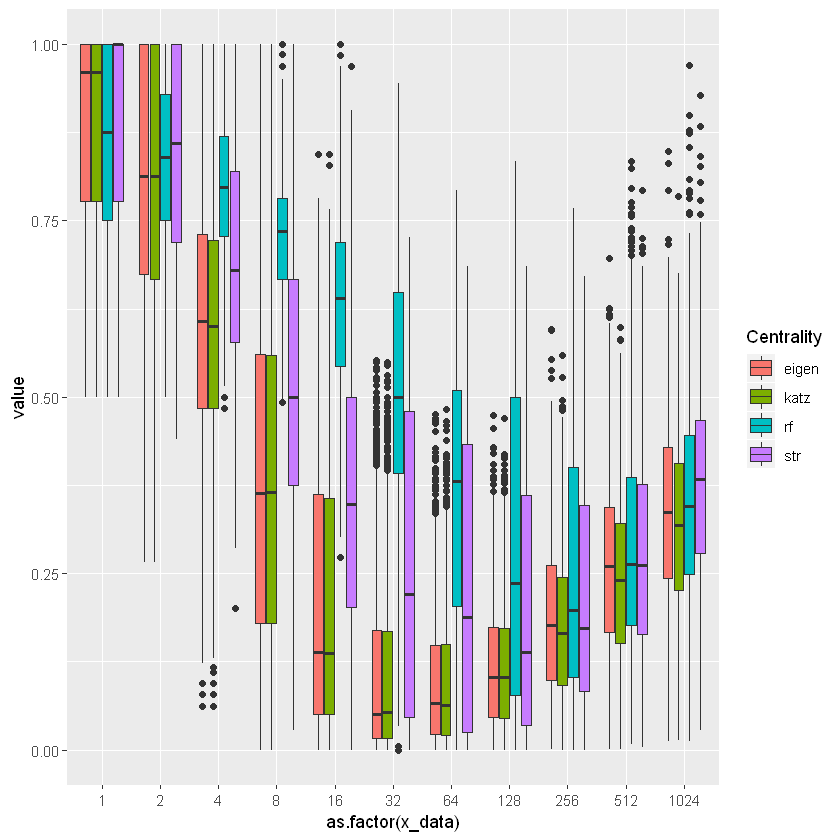

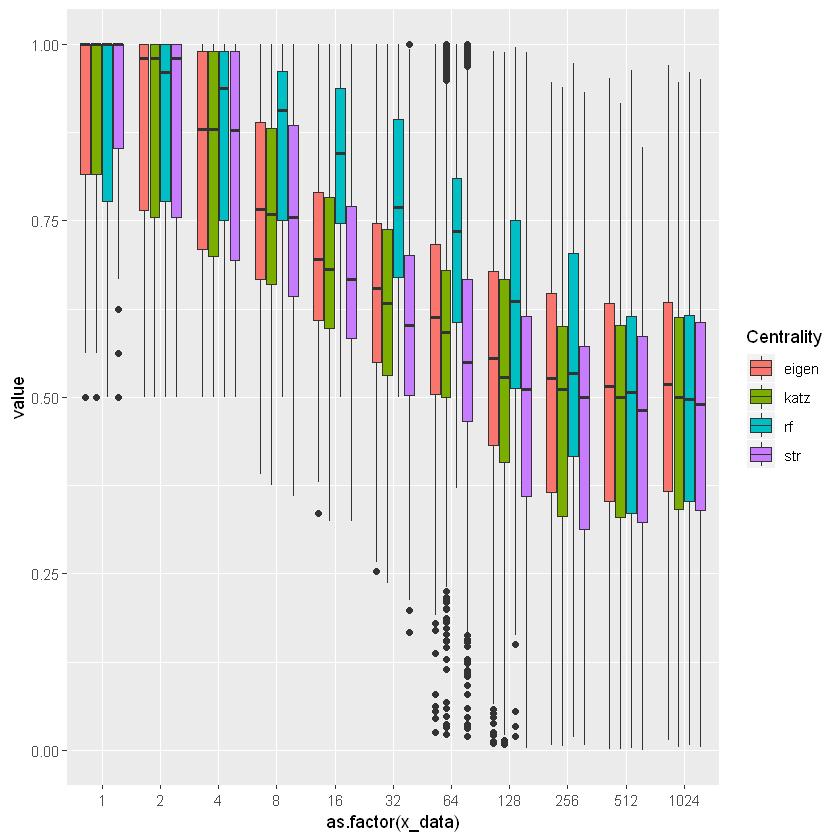

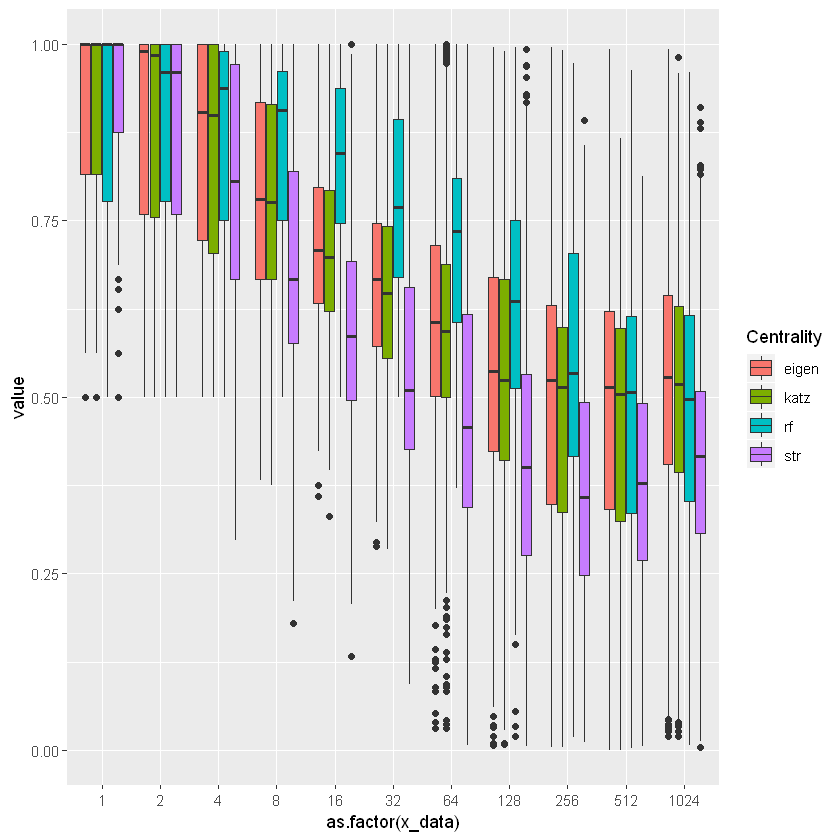

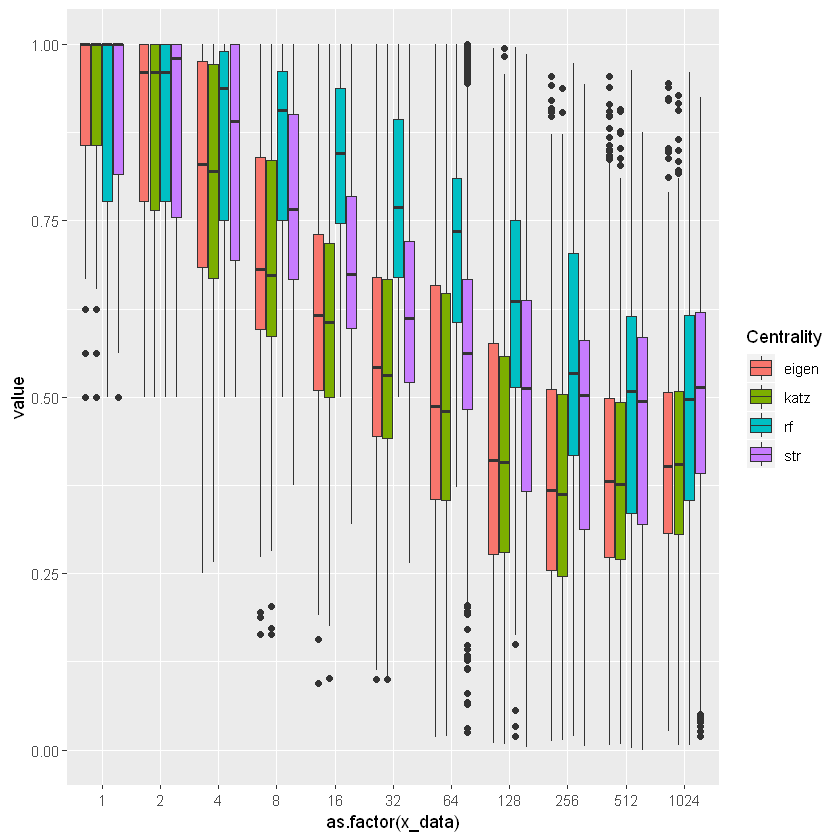

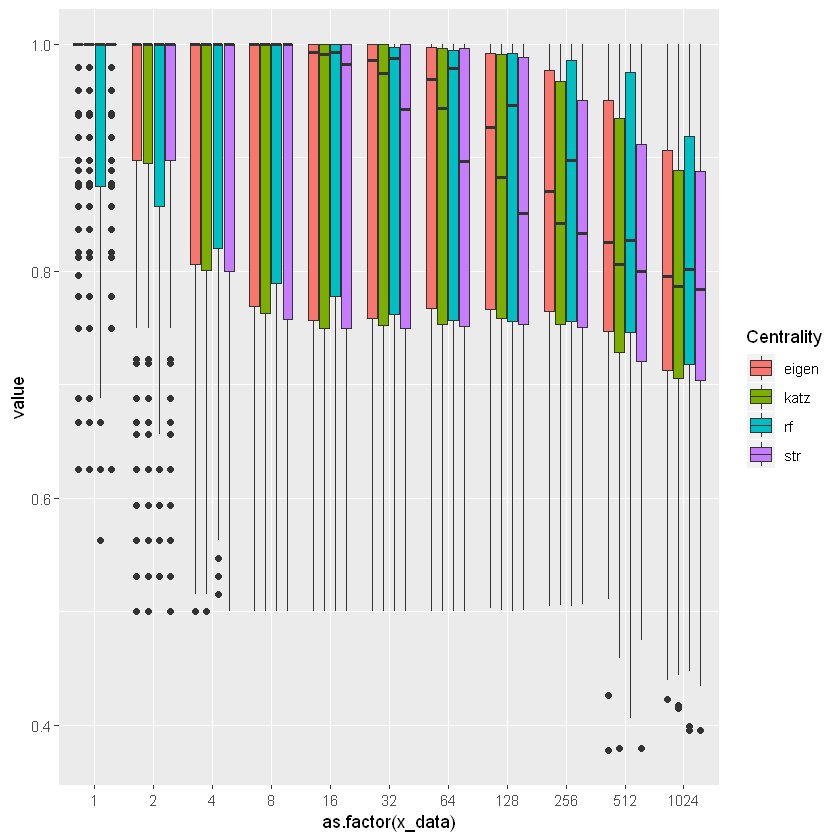

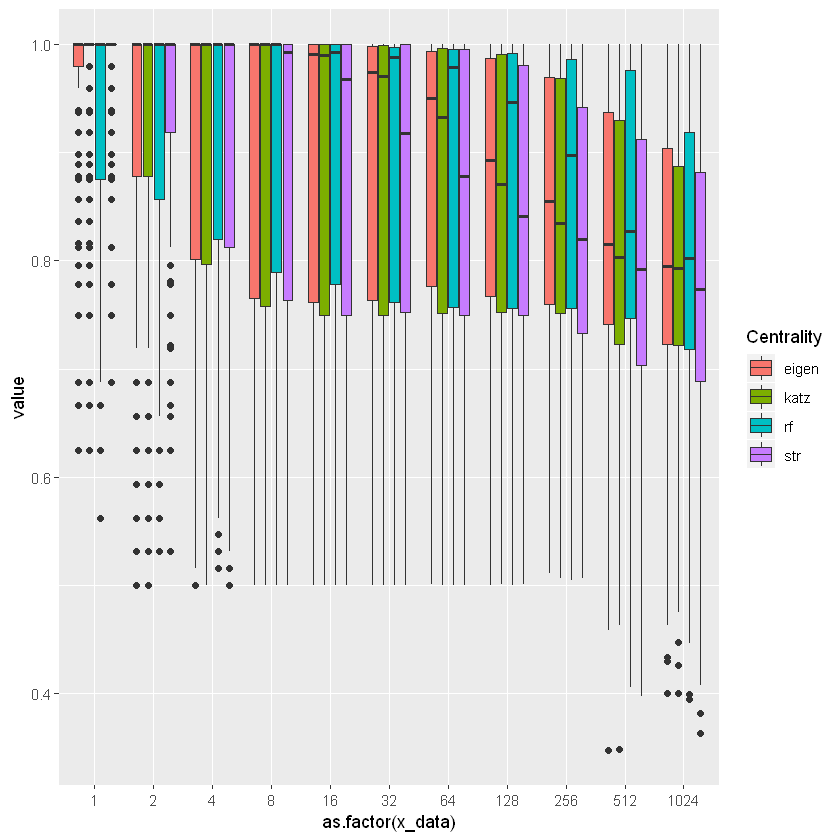

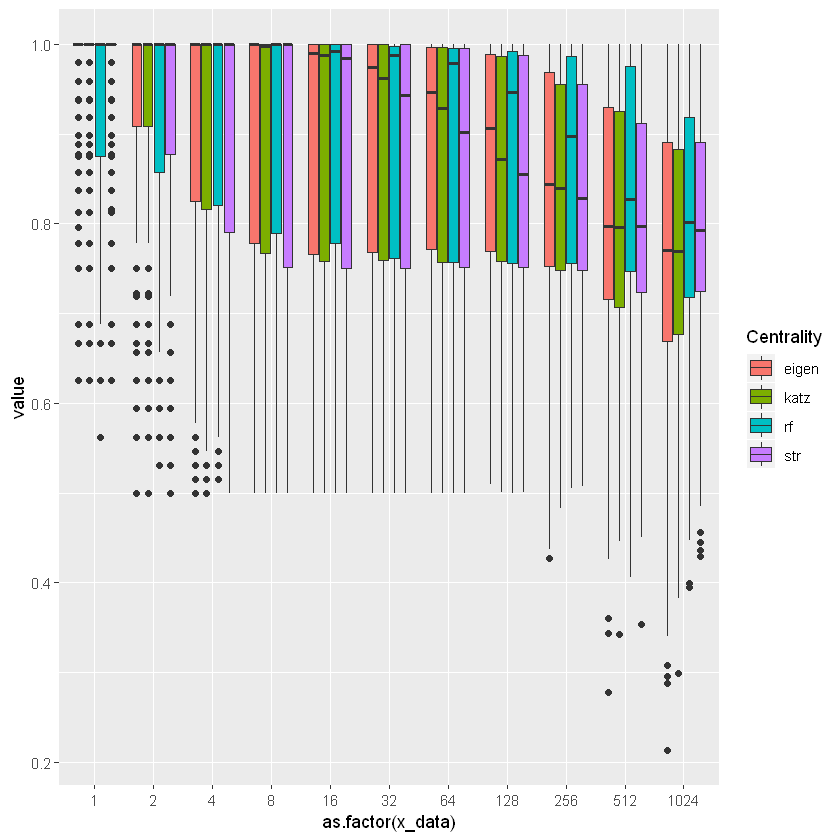

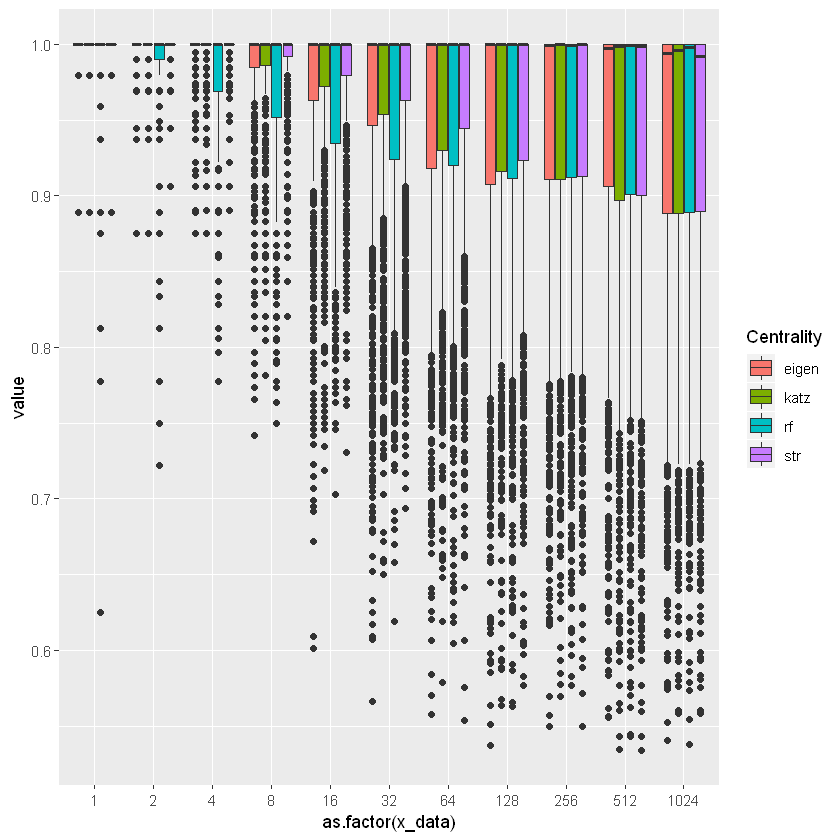

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]


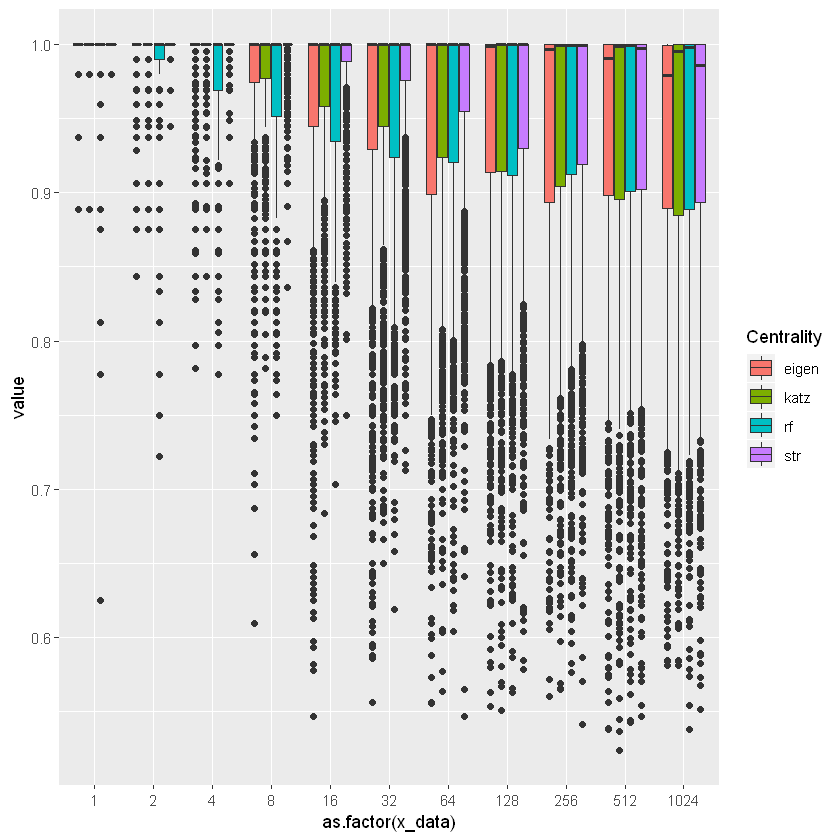

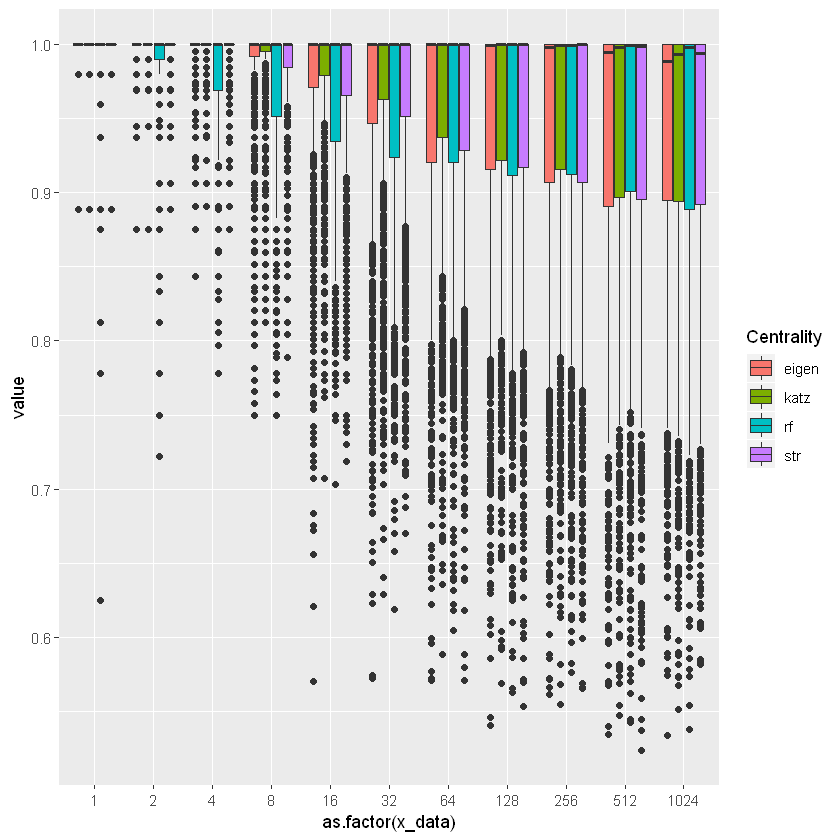

In [45]:
prediction_type <- "regression" #classification
scores_path     <- paste0('E:/Mestrado_ranker/R_output_analisys/data_scores/',prediction_type,'/')
files <- list.files(path=scores_path, full.names = TRUE, pattern = "\\.csv$")

for (file in files[1]){
  vec_newformat <- read.table(file, header=TRUE, sep=",")
  # NDC --- transposed of DNC
  #saving all 12 subsets for NDC in ndc[[]] list
  ndc <- list() #Noise Dataset Centrality (NDC)
  i=1
  for(noi in c(5,10,20,40)){ #for each noise percentage on examples
    for(ori in c("g", "in", "out")){ #for each orientation in graph
      ndc[[i]] <- subset(vec_newformat, noise == noi & (orientation == ori | centrality_or_forest == "f"))
      ndc[[i]]$title <- paste0('Noise Rate: ', noi,'%;', ' Orientation: ', ori)
      i=i+1
    }
  }
}

require(ggplot2)
require(gridExtra)

p <- list()
i <- 1
for (data_subset in ndc){
    dataset <- data_subset
    x_data <- as.factor(data_subset$R)
    y_data <- data_subset$value
    group_by_data <- data_subset$centrality
    group_by_label <- 'Centrality'
    
    p[[i]] <- ggplot(dataset,                
                      aes(x    = as.factor(x_data),                  #x_data
                          y    = value,              #y_data
                          fill = group_by_data)) +      #group_by_data
                    geom_boxplot()+ 
                    labs(fill=group_by_label)
              
    i=i+1
}           
p